# ICR - Identifying Age-Related Conditions Dataset with Decision Tree Classifier, Gradient Boost Classifier, Random Forest Classifier and Light GBM Classifier.

This notebook walks you through how to train a baseline Decision Tree Classifier, Gradient Boost Classifier, Random Forest Classifier and Light GBM classifier using SKlearn and XGMod on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

    Import Models
    Import Pandas
    
    Import dataset
    Explore Dataset
    
    Define model parameters
    Fit model to dataset
    
    Print model summary.
    
These models are baseline models for classification problems.

# Import the libraries

In [1]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss
import optuna
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
import time

# Load the Dataset

In [2]:
dataset_df = pd.read_csv( 'train.csv', header = 'infer' )
print( "Full train dataset shape is {}".format( dataset_df.shape ) )

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [3]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [4]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

#Removing the columns of object datatypes

In [6]:
dataset_df = dataset_df.drop( [ 'EJ' ], axis = 1 )
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

## Pie chart for label column: Class

<AxesSubplot:ylabel='count'>

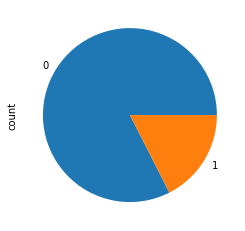

In [7]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot( kind="pie" )

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

In [8]:
# From the dataset info, we see that there are three columns that are of object datatype
# Store all the numerical column names into a list
NUM_FEATURE_COLUMNS = [ i for i in dataset_df.columns if i not in [ "Id", "EJ", "Class" ] ]

## Let us now plot the first 6 numerical columns and their values using bar charts.

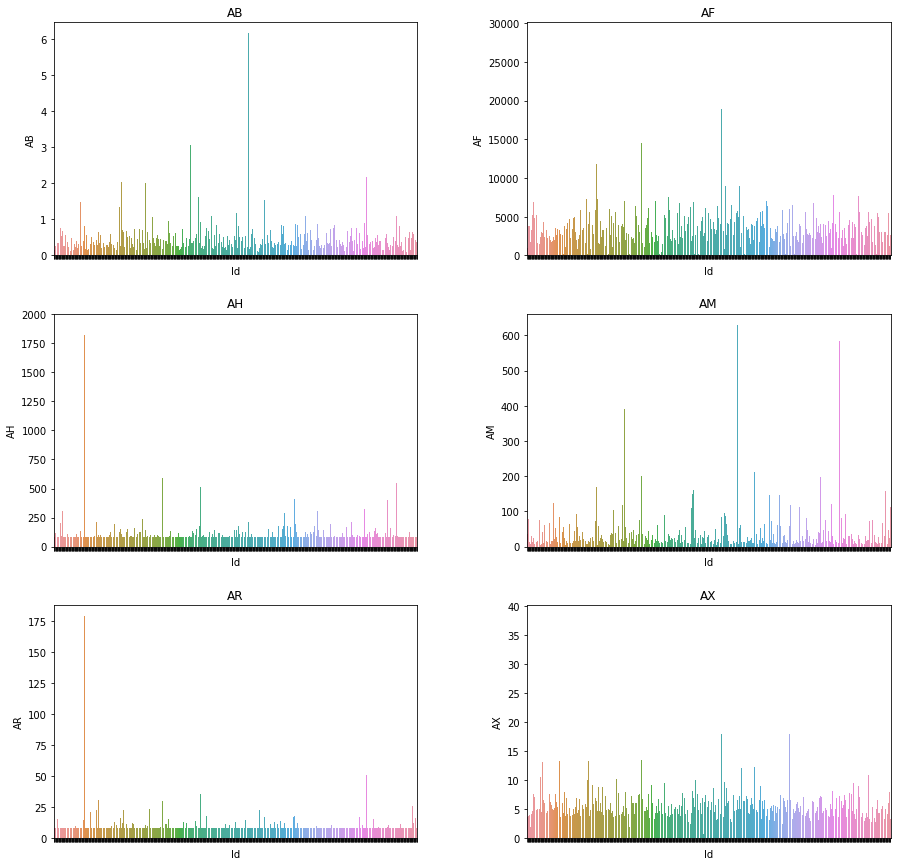

In [9]:
figure, axis = plt.subplots( 3, 2, figsize = ( 15, 15 ) )
plt.subplots_adjust( hspace = 0.25, wspace = 0.3 )

for i, column_name in enumerate( NUM_FEATURE_COLUMNS[ :6 ] ):
    row = i//2
    col = i % 2
    bp = sns.barplot( ax = axis[ row, col ], x = dataset_df[ 'Id' ], y = dataset_df[ column_name ] )
    bp.set( xticklabels = [] )
    axis[ row, col ].set_title( column_name )
plt.show()

## Checking the distribution of some columns against the target column

<AxesSubplot:xlabel='Class', ylabel='BC'>

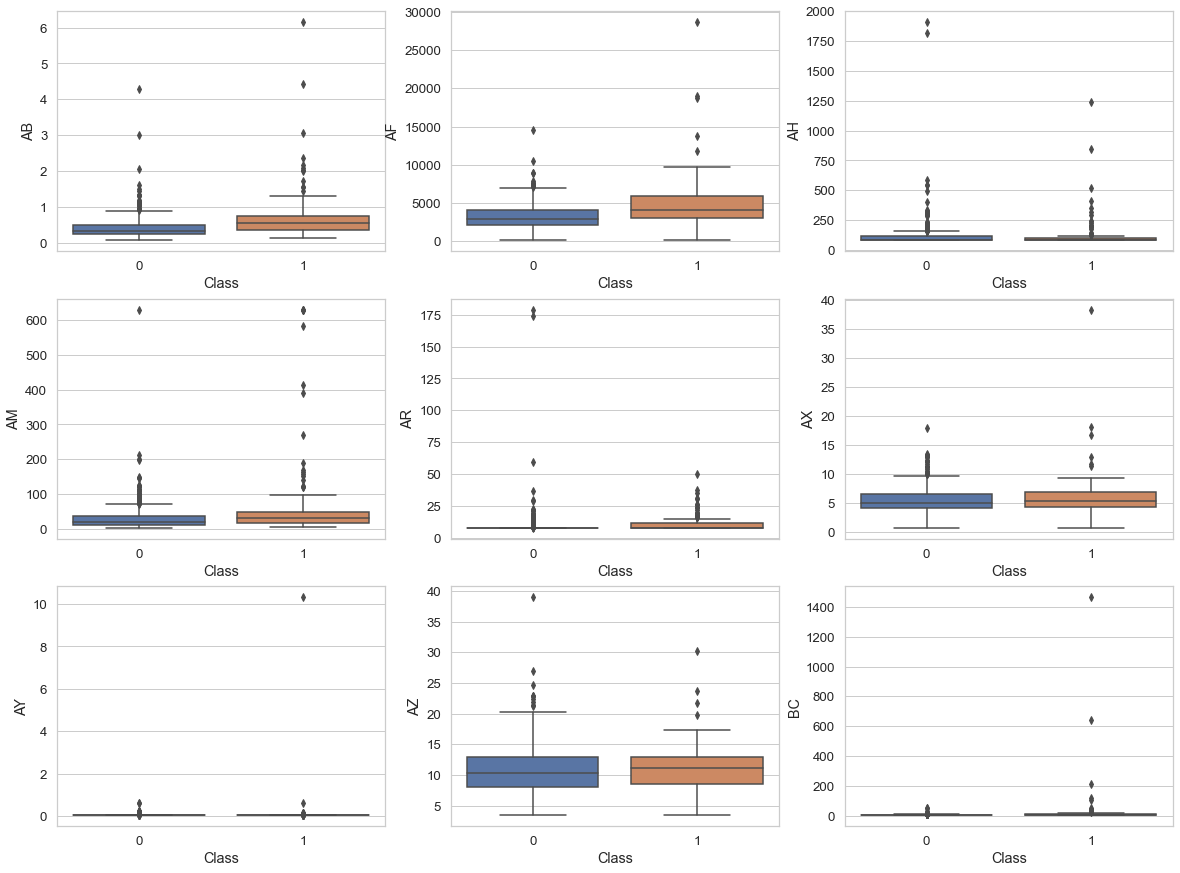

In [10]:
sns.set( style="whitegrid", font_scale = 1.2 )
plt.subplots( figsize = ( 20, 15 ) )

plt.subplot( 3, 3, 1 )
sns.boxplot( x = 'Class', y = 'AB', data = dataset_df )

plt.subplot( 3, 3, 2 )
sns.boxplot( x = 'Class', y = 'AF', data = dataset_df )

plt.subplot( 3, 3, 3 )
sns.boxplot( x = 'Class', y = 'AH', data = dataset_df )

plt.subplot( 3, 3, 4 )
sns.boxplot( x = 'Class', y = 'AM', data = dataset_df )

plt.subplot( 3, 3, 5 )
sns.boxplot( x = 'Class', y = 'AR', data = dataset_df )

plt.subplot( 3, 3, 6 )
sns.boxplot( x = 'Class', y = 'AX', data = dataset_df )

plt.subplot( 3, 3, 7 )
sns.boxplot( x = 'Class', y = 'AY', data = dataset_df )

plt.subplot( 3, 3, 8 )
sns.boxplot( x = 'Class', y = 'AZ', data = dataset_df )

plt.subplot( 3, 3, 9 )
sns.boxplot( x = 'Class', y = 'BC', data = dataset_df)

## We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [11]:
FEATURE_COLUMNS = [ i for i in dataset_df.columns if i not in [ "Id" ] ]

print( FEATURE_COLUMNS )

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class']


## Here We split the data into training and testing data

In [12]:
X = dataset_df.drop( [ 'Class' ], axis = 1 )
y = dataset_df[ 'Class' ]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 30 )

type( X_train )
type( y_train )

pandas.core.series.Series

In [13]:
imputer = SimpleImputer( strategy = "mean" )

X_train.set_index( 'Id' )
X_test.set_index( 'Id' )
X_train = X_train.drop( 'Id', axis = 1 )
X_test = X_test.drop( 'Id', axis = 1 )

for x in X_train.columns:
    imputer = imputer.fit( X_train[ [ x ] ] )
    X_train[ x + "_Imputed" ] = imputer.transform( X_train[ [ x ] ] )
    X_train = X_train.drop( [ x ], axis = 1 )

    X_test[ x + "_Imputed" ] = imputer.transform( X_test[ [ x ] ] )
    X_test = X_test.drop( [ x ], axis = 1 )

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 236 to 212
Data columns (total 55 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AB_Imputed   124 non-null    float64
 1   AF_Imputed   124 non-null    float64
 2   AH_Imputed   124 non-null    float64
 3   AM_Imputed   124 non-null    float64
 4   AR_Imputed   124 non-null    float64
 5   AX_Imputed   124 non-null    float64
 6   AY_Imputed   124 non-null    float64
 7   AZ_Imputed   124 non-null    float64
 8   BC_Imputed   124 non-null    float64
 9   BD _Imputed  124 non-null    float64
 10  BN_Imputed   124 non-null    float64
 11  BP_Imputed   124 non-null    float64
 12  BQ_Imputed   124 non-null    float64
 13  BR_Imputed   124 non-null    float64
 14  BZ_Imputed   124 non-null    float64
 15  CB_Imputed   124 non-null    float64
 16  CC_Imputed   124 non-null    float64
 17  CD _Imputed  124 non-null    float64
 18  CF_Imputed   124 non-null    float64
 19  CH_Imputed 

## Check whether the train and test have instances of all the class

In [15]:
print( np.unique( y_train ) )
print( np.unique( y_test ) )

[0 1]
[0 1]


## We now test the first ( Random Forest Classifier )

In [16]:
RandFor = RandomForestClassifier( max_depth = 3, min_samples_split = 2, n_estimators = 50, random_state = 1 )
RandFor.fit( X_train, y_train )

y_pred_RandFor_Train = RandFor.predict( X_train )
y_pred = RandFor.predict( X_test )


#print( y_pred_RandFor_Train )
sc0 = metrics.accuracy_score( y_pred, y_test )
lgl_rand = log_loss( y_test, y_pred )

## The Next Model ( Decision Tree, Gradient Boost and XG Boost )

In [17]:
# Decision Tree
DecTree = DecisionTreeClassifier()
DecTree.fit( X_train, y_train )
y_pred_DecTree_Train = DecTree.predict( X_train )
y_pred = DecTree.predict( X_test )

sc1 = metrics.accuracy_score( y_pred, y_test )
lgl_decTree = log_loss( y_test, y_pred )


# Gradient Boost Classifier
gbmMod = GradientBoostingClassifier( max_depth = 3, n_estimators = 100, learning_rate = 0.05, random_state = 1 )
gbmMod.fit( X_train, y_train )
y_pred_gbmMod_Train = gbmMod.predict(X_train)
y_pred = gbmMod.predict(X_test)

sc2 = metrics.accuracy_score( y_pred, y_test )
lgl_gbmMod = log_loss( y_test, y_pred )


xgboost = XGBClassifier( max_depth = 3, n_estimators = 100, learning_rate = 0.05, random_state = 1 )
xgboost.fit( X_train, y_train )
y_pred_xgboost_Train = xgboost.predict(X_train)
y_pred = xgboost.predict(X_test)

sc3 = metrics.accuracy_score( y_pred, y_test )
lgl_xgboost = log_loss( y_test, y_pred )

## The next model ( Light Gradient Boost )

In [18]:
#Light Gradient Boost
params = {
      "cat_l2": 10,
      "cat_smooth": 10,
      "colsample_bytree": 0.8,
      "feature_fraction_bynode":  0.8,
      "learning_rate": 0.03,
      "max_depth": 6,
      "min_child_samples": 63,
      "min_data_per_group": 100,
      "n_estimators": 200,
      "num_leaves": 63,
      "path_smooth": 0,
      "reg_alpha":  0.05,
      "reg_lambda": 0.05,
      "subsample_freq": 1,
      "subsample": 0.8,
      "max_bin": 127,
      "extra_trees": False,
      "is_unbalance": True,
      "boosting_type": 'gbdt',
      "n_jobs": 1,
      "verbosity": -1,
      "seed": 77,
}
        
fit_params= {
    'feature_name': "auto",
}

start = time.time()
LightGBM = LGBMClassifier(**params)

# The more CV, the better our estimate of the score
inner_cv_scores = cross_validate( LightGBM, X_train, y_train, 
                                 fit_params=fit_params, 
                                 cv=15, 
                                 scoring="roc_auc", 
                                 n_jobs=5, 
                                 verbose=0, 
                                 return_train_score = True )
cv_scores = inner_cv_scores[ 'test_score' ].tolist()
duration = time.time() - start

print( "CV Scores: " )
print( [ "{:0.4f}".format( cv_score ) for cv_score in cv_scores ] )
print( "CV Score mean: {:.4f} ".format( np.mean( cv_scores ) ) )
print( "CV Score range: {:0.4f} -- {:0.4f}".format( np.mean( cv_scores ) - np.std( cv_scores ), np.mean( cv_scores ) + np.std( cv_scores ) ) )
print( "Fit times: {}".format( duration ) )
print( "Total duration: {}".format( duration ) )

CV Scores: 
['1.0000', '0.9753', '0.9444', '0.9877', '0.9074', '0.9074', '0.9444', '1.0000', '0.9877', '0.9630', '0.9383', '0.9630', '0.9568', '0.8889', '0.8974']
CV Score mean: 0.9508 
CV Score range: 0.9150 -- 0.9865
Fit times: 4.813329458236694
Total duration: 4.813329458236694


In [19]:
LightGBM = LGBMClassifier( **params )
LightGBM = LightGBM.fit( X_train, y_train, **fit_params )

y_pred = LightGBM.predict( X_test )

sc4 = metrics.accuracy_score( y_pred, y_test )
lgl_lightGBM = log_loss( y_test, y_pred )

In [20]:
print( DecTree.feature_importances_ )
print( RandFor.feature_importances_ )
print( gbmMod.feature_importances_ )
print( xgboost.feature_importances_ )
print( LightGBM.feature_importances_ )

[0.03107873 0.00623523 0.01645344 0.         0.         0.
 0.05391208 0.         0.07872524 0.         0.         0.01175246
 0.         0.00416167 0.         0.         0.         0.
 0.         0.         0.         0.12304671 0.         0.04211298
 0.         0.00423182 0.08472657 0.         0.         0.03268819
 0.         0.0068556  0.26956798 0.         0.0182816  0.
 0.         0.06119673 0.         0.         0.00877267 0.
 0.         0.0091408  0.         0.04726757 0.01697577 0.
 0.         0.01175246 0.02448429 0.         0.03027565 0.
 0.00630375]
[0.0256633  0.04006212 0.00264553 0.01536112 0.00911092 0.00557066
 0.00540716 0.00436246 0.03754675 0.00107845 0.01019415 0.00345054
 0.02414138 0.00939428 0.00248415 0.00402328 0.01070593 0.0021948
 0.00146778 0.00144947 0.00633648 0.06325608 0.00276722 0.01505208
 0.00055685 0.07603408 0.04265033 0.00839863 0.01783618 0.0440949
 0.00735274 0.00248367 0.12112501 0.         0.00597182 0.00716219
 0.00771339 0.00739759 0.0560077

## Accuracy and Log Loss for all models

In [21]:
# Compare accuracy of models
pd.DataFrame( [ [ 'Random Forest Classifier', sc0,  lgl_rand ], [ 'Decision Tree', sc1, lgl_decTree ], [ 'Gradient Boost', sc2, lgl_gbmMod ], [ 'XG Boost', sc3, lgl_xgboost ], [ 'Light GBM', sc4, lgl_lightGBM ] ],
                                 columns=[ 'Model', 'Accuracy', 'Log Loss' ] )

,Model,Accuracy,Log Loss
0,Random Forest Classifier,0.903226,3.488095
1,Decision Tree,0.887097,4.069445
2,Gradient Boost,0.911290,3.197421
3,XG Boost,0.919355,2.906746
4,Light GBM,0.935484,2.325397


In [22]:
train2 = pd.read_csv( 'train.csv', header = 'infer', index_col = 'Id' )

In [23]:
X_train_noclass = train2.drop( columns= 'Class' )

In [24]:
X_train_noclass = pd.get_dummies( X_train_noclass, columns = [ 'EJ' ] )

In [25]:
imputer = IterativeImputer( estimator = LinearRegression() )
imputer = imputer.fit( X_train_noclass )

imputer.transform( X_train_noclass )

X_train_imputed = imputer.transform( X_train_noclass )

X_train_imputed = pd.DataFrame( X_train_imputed )

X_train_imputed.index = X_train_noclass.index
X_train_imputed.columns = X_train_noclass.columns

In [26]:
from scipy.stats import uniform, randint
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

X = X_train_imputed
y = train2[ 'Class' ]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42 )

# Apply oversampling to the training set
ros = RandomOverSampler( random_state = 42 )
X_train_resampled, y_train_resampled = ros.fit_resample( X_train, y_train )


indices = ros.sample_indices_
X_train_resampled = X_train.iloc[ indices ]

#scaling data
scaler = StandardScaler()
scaler.fit( X_train )

X_train_scaled = scaler.transform( X_train_resampled )
X_test_scaled = scaler.transform( X_test )


# Create an instance of the XGBoost classifier
xgbMod =  xgb.XGBClassifier( random_state = 42 )

# Define the hyperparameter search space
params = { 'learning_rate': uniform( 0.01, 1.0 ),
          'max_depth': randint( 1, 10 ), 'num_leaves': randint( 1, 32 ),
          'min_samples_leaf': randint( 20, 100 ), 'Max_bin': randint( 0, 255 ),
          'lambda_l1': uniform( 0.0, 1.0 ), 'lambda_l2': uniform( 0.0, 1.0 ) }

k_fold = KFold( n_splits = 15, shuffle = True, random_state = 42 )

search = RandomizedSearchCV( xgbMod, param_distributions = params, n_iter = 100, scoring = 'f1_macro', cv = k_fold, verbose = 1 )
search.fit( X_train_scaled, y_train_resampled )

# Make predictions on the test set
y_pred_xgb = search.predict( X_test_scaled )

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[05:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:02:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Paramete

In [27]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss,classification_report

print( classification_report( y_test, y_pred_xgb ) )

print( "Accuracy = {:.2f}".format( accuracy_score( y_test, y_pred_xgb ) ) )
print( "Kappa = {:.2f}".format( cohen_kappa_score( y_test, y_pred_xgb ) ) )
print( "F1 Score = {:.2f}".format( f1_score( y_test, y_pred_xgb ) ) )
print( "Log Loss = {:.2f}".format( log_loss( y_test, y_pred_xgb ) ) )

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       101
           1       0.91      0.87      0.89        23

    accuracy                           0.96       124
   macro avg       0.94      0.92      0.93       124
weighted avg       0.96      0.96      0.96       124

Accuracy = 0.96
Kappa = 0.86
F1 Score = 0.89
Log Loss = 1.45


In [28]:
best_estimator = search.best_estimator_

best_estimator

XGBClassifier(Max_bin=75, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_l1=0.38511561625969104,
              lambda_l2=0.29624784453153064, learning_rate=0.583107251178829,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, min_samples_leaf=93, missing=nan,
              monotone_constraints=None, n_estimators=100, ...)

In [29]:
best_feature = search.best_estimator_.feature_importances_

print(best_feature)

[0.10586634 0.00943318 0.0072795  0.00961406 0.         0.00951908
 0.00487886 0.00305736 0.02371054 0.0148774  0.00114274 0.0055338
 0.01974979 0.01848133 0.         0.01448468 0.00926047 0.00596509
 0.01573885 0.00282757 0.01951064 0.08570904 0.04304646 0.00939898
 0.00249115 0.0466395  0.00361292 0.         0.00417492 0.04167714
 0.02446036 0.00539158 0.10970185 0.01016537 0.00406952 0.03222363
 0.0359016  0.0170723  0.01164219 0.0148056  0.0184007  0.01919606
 0.00363486 0.01460303 0.00243154 0.0059671  0.00436591 0.04689198
 0.00682619 0.00015269 0.00020089 0.00068076 0.0280124  0.0047008
 0.0408197  0.         0.        ]


In [30]:
X_train_resampled = X_train.iloc[indices]

In [31]:
X_test_scaled

array([[-1.69745368e-03,  7.18798462e-01,  5.38679506e-01, ...,
        -8.12121532e-01, -7.38548946e-01,  7.38548946e-01],
       [ 1.25792811e+00,  3.62676695e-01,  3.08433755e+00, ...,
        -8.09464920e-01, -7.38548946e-01,  7.38548946e-01],
       [-3.50382730e-01, -1.89401886e-01, -2.52523210e-01, ...,
         1.32128181e+00,  1.35400640e+00, -1.35400640e+00],
       ...,
       [-6.29330952e-01, -6.43263672e-01, -2.52523210e-01, ...,
         1.32128181e+00,  1.35400640e+00, -1.35400640e+00],
       [ 3.31710740e-02, -1.00634845e-01, -2.52523210e-01, ...,
        -8.01409994e-01, -7.38548946e-01,  7.38548946e-01],
       [-5.40002452e-02, -5.26684381e-01, -2.52523210e-01, ...,
        -8.06474016e-01, -7.38548946e-01,  7.38548946e-01]])

In [32]:
X_test_scaled = pd.DataFrame( X_test_scaled )

In [33]:
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-0.001697,0.718798,0.538680,-0.358980,-0.173278,0.657014,-0.318591,-0.206954,-0.000308,-0.167178,...,-0.039186,-0.258800,-0.830929,-0.426529,-0.728675,0.286573,-0.336192,-0.812122,-0.738549,0.738549
1,1.257928,0.362677,3.084338,0.445802,-0.173278,-0.923679,1.075303,-1.640940,0.066093,-0.019068,...,-0.036150,-0.179056,-0.844546,-0.426529,-0.642239,0.162345,-0.240561,-0.809465,-0.738549,0.738549
2,-0.350383,-0.189402,-0.252523,-0.341267,-0.123249,-0.120599,-0.208836,0.238569,-0.102247,-0.675630,...,-0.063470,-0.258800,-1.323971,0.156503,-0.251742,-0.120373,0.217702,1.321282,1.354006,-1.354006
3,0.957187,1.140825,-0.146496,-0.142301,-0.173278,-0.745405,-0.318591,-0.729836,-0.009558,0.116923,...,-0.053721,0.848238,-0.341643,-0.426529,-0.572592,0.407164,-0.341401,-0.804204,-0.738549,0.738549
4,1.689426,2.292550,0.566903,1.140183,0.281300,1.400670,-0.318591,1.315849,0.276397,-0.229587,...,-0.059632,-0.075857,-1.064772,-0.426529,-0.504542,1.485207,-0.036386,-0.814293,-0.738549,0.738549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-0.267570,-0.740292,-0.252523,-0.424909,0.448895,-1.404169,-0.318591,-0.924663,-0.102247,0.133687,...,-0.056974,0.017959,-0.279660,0.617756,-0.585571,0.261306,1.444632,-0.810657,-0.738549,0.738549
120,0.800279,0.252005,0.160560,-0.306304,-0.173278,2.915148,-0.318591,1.172594,-0.102247,-0.193431,...,-0.048010,0.041414,1.360058,-0.289392,-0.325580,-1.112664,-0.547637,-0.793795,-0.738549,0.738549
121,-0.629331,-0.643264,-0.252523,-0.232044,-0.173278,-1.142701,-0.252738,-1.640940,-0.102247,0.935031,...,-0.052784,-0.258800,0.503573,0.667368,-0.408128,-0.652122,0.690288,1.321282,1.354006,-1.354006
122,0.033171,-0.100635,-0.252523,0.409366,-0.173278,0.011833,-0.318591,0.437694,-0.102247,1.342205,...,-0.051791,0.613696,0.545834,-0.199713,0.923087,0.462291,0.078017,-0.801410,-0.738549,0.738549


In [34]:
X_test

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
Id,,,,,,,,,,,,,,,,,,,,,
1360fac6a227,0.478576,5192.25520,194.576478,13.230384,8.138688,7.290957,0.025578,9.705080,8.588216,4866.40538,...,1.85861,0.067730,12.418170,72.611063,434.357883,34.411808,36.769312,0.050038,0.0,1.0
f03b541de10c,1.096024,4348.11080,546.489750,72.469800,8.138688,3.167092,0.102921,3.396778,13.381312,5281.91734,...,2.02884,0.182871,12.283291,72.611063,2184.856740,33.204344,40.169496,0.077344,0.0,1.0
1e5e59a7f331,0.307656,3039.47402,85.200147,14.534221,8.715528,5.262246,0.031668,11.665002,1.229900,3439.97465,...,0.49706,0.067730,7.534620,139.519779,10093.114350,30.456385,56.463116,21.978000,1.0,0.0
79b44ed25c29,0.948606,6192.61907,99.857394,29.179934,8.138688,3.632190,0.025578,7.404850,7.920556,5663.43185,...,1.04371,1.666158,17.264512,72.611063,3595.331772,35.583923,36.584128,0.131416,0.0,1.0
2cddd2d70d72,1.307538,8922.64648,198.478110,123.582688,13.380066,9.231078,0.025578,16.404106,28.561792,4691.32051,...,0.71224,0.331877,10.101972,72.611063,4973.463261,46.062259,47.428966,0.027720,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.46099,...,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096,0.0,1.0
29cba3a7b8dc,0.871692,4085.77675,142.305060,17.107828,8.138688,13.182192,0.025578,15.773906,1.229900,4792.75356,...,1.36387,0.501202,34.119736,88.348834,8597.759661,20.811553,29.251356,0.238408,0.0,1.0
2e4e80b95e24,0.170920,1963.64850,85.200147,22.574033,8.138688,2.595687,0.029232,3.396778,1.229900,7958.58332,...,1.09620,0.067730,25.636312,198.146620,6926.005926,25.287916,73.265992,21.978000,1.0,0.0


In [35]:
X_test_scaled.index = X_test.index

In [36]:
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
Id,,,,,,,,,,,,,,,,,,,,,
1360fac6a227,-0.001697,0.718798,0.538680,-0.358980,-0.173278,0.657014,-0.318591,-0.206954,-0.000308,-0.167178,...,-0.039186,-0.258800,-0.830929,-0.426529,-0.728675,0.286573,-0.336192,-0.812122,-0.738549,0.738549
f03b541de10c,1.257928,0.362677,3.084338,0.445802,-0.173278,-0.923679,1.075303,-1.640940,0.066093,-0.019068,...,-0.036150,-0.179056,-0.844546,-0.426529,-0.642239,0.162345,-0.240561,-0.809465,-0.738549,0.738549
1e5e59a7f331,-0.350383,-0.189402,-0.252523,-0.341267,-0.123249,-0.120599,-0.208836,0.238569,-0.102247,-0.675630,...,-0.063470,-0.258800,-1.323971,0.156503,-0.251742,-0.120373,0.217702,1.321282,1.354006,-1.354006
79b44ed25c29,0.957187,1.140825,-0.146496,-0.142301,-0.173278,-0.745405,-0.318591,-0.729836,-0.009558,0.116923,...,-0.053721,0.848238,-0.341643,-0.426529,-0.572592,0.407164,-0.341401,-0.804204,-0.738549,0.738549
2cddd2d70d72,1.689426,2.292550,0.566903,1.140183,0.281300,1.400670,-0.318591,1.315849,0.276397,-0.229587,...,-0.059632,-0.075857,-1.064772,-0.426529,-0.504542,1.485207,-0.036386,-0.814293,-0.738549,0.738549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
049232ca8356,-0.267570,-0.740292,-0.252523,-0.424909,0.448895,-1.404169,-0.318591,-0.924663,-0.102247,0.133687,...,-0.056974,0.017959,-0.279660,0.617756,-0.585571,0.261306,1.444632,-0.810657,-0.738549,0.738549
29cba3a7b8dc,0.800279,0.252005,0.160560,-0.306304,-0.173278,2.915148,-0.318591,1.172594,-0.102247,-0.193431,...,-0.048010,0.041414,1.360058,-0.289392,-0.325580,-1.112664,-0.547637,-0.793795,-0.738549,0.738549
2e4e80b95e24,-0.629331,-0.643264,-0.252523,-0.232044,-0.173278,-1.142701,-0.252738,-1.640940,-0.102247,0.935031,...,-0.052784,-0.258800,0.503573,0.667368,-0.408128,-0.652122,0.690288,1.321282,1.354006,-1.354006


In [37]:
# Convert y_pred_xgb to a DataFrame
y_pred_df = pd.DataFrame( y_pred_xgb, columns = [ 'class_0' ] )

# Calculate probabilities for class_1 as 1 - class_0
y_pred_df[ 'class_1' ] = 1 - y_pred_df[ 'class_0' ]

# Create the submission DataFrame using the 'Id' index from X_test_scaled
submission = pd.DataFrame( X_test_scaled.index, columns = [ 'Id' ] )
submission[ [ 'class_0', 'class_1' ] ] = y_pred_df[ [ 'class_0', 'class_1' ] ]
submission.to_csv( 'submission.csv', index = False )

In [38]:
from sklearn.feature_selection import VarianceThreshold

X = X_train_imputed
y = train2[ 'Class' ]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42 )

# Apply oversampling to the training set
ros = RandomOverSampler( random_state = 42 )
X_train_resampled, y_train_resampled = ros.fit_resample( X_train, y_train )


indices = ros.sample_indices_
X_train_resampled = X_train.iloc[ indices ]

sel = VarianceThreshold( threshold = ( 0.1 ) );
sel = sel.fit( X_train_resampled );

#scaling data
scaler = StandardScaler()
scaler.fit( X_train )

X_train_scaled = scaler.transform( X_train_resampled )
X_test_scaled = scaler.transform( X_test )

# Create an instance of the XGBoost classifier
#xgb_clf = xgb.XGBClassifier(random_state=42)
xgbMod =  xgb.XGBClassifier( random_state = 42 )

# Define the hyperparameter search space
params = { 'learning_rate': uniform( 0.01, 1.0 ),
          'max_depth': randint( 1, 10 ), 'num_leaves': randint( 1, 32 ),
          'min_samples_leaf': randint( 20, 100 ), 'Max_bin': randint( 0, 255 ),
          'lambda_l1': uniform( 0.0, 1.0 ), 'lambda_l2': uniform( 0.0, 1.0 ) }

k_fold = KFold( n_splits = 15, shuffle = True, random_state = 42 )

search = RandomizedSearchCV( xgbMod, param_distributions = params, n_iter = 100, scoring = 'f1_macro', cv = k_fold, verbose = 1 )
search.fit( X_train_scaled, y_train_resampled )

# Make predictions on the test set
y_pred_xgb = search.predict( X_test_scaled )

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[05:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:08:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "Max_bin", "lambda_l1", "lambda_l2", "min_samples_leaf", "num_leaves" } are not used.

[05:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Paramete

In [39]:
print( classification_report( y_test, y_pred_xgb ) )

print( "Accuracy = {:.2f}".format( accuracy_score( y_test, y_pred_xgb ) ) )
print( "Kappa = {:.2f}".format( cohen_kappa_score( y_test, y_pred_xgb ) ) )
print( "F1 Score = {:.2f}".format( f1_score( y_test, y_pred_xgb ) ) )
print( "Log Loss = {:.2f}".format( log_loss( y_test, y_pred_xgb ) ) )

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       101
           1       0.89      0.74      0.81        23

    accuracy                           0.94       124
   macro avg       0.92      0.86      0.89       124
weighted avg       0.93      0.94      0.93       124

Accuracy = 0.94
Kappa = 0.77
F1 Score = 0.81
Log Loss = 2.33


In [40]:
best_estimator = search.best_estimator_

best_estimator

XGBClassifier(Max_bin=71, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_l1=0.30042228600192267,
              lambda_l2=0.9289580433486825, learning_rate=0.2928643460028777,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, min_samples_leaf=62, missing=nan,
              monotone_constraints=None, n_estimators=100, ...)

In [41]:
best_feature = search.best_estimator_.feature_importances_

print(best_feature)

[0.07670977 0.02924198 0.007838   0.01112284 0.00410192 0.00345818
 0.01554577 0.00402533 0.00193929 0.01580894 0.00852974 0.01011031
 0.02816109 0.01657283 0.         0.00238976 0.0197636  0.00618724
 0.00977537 0.00580142 0.0043584  0.0932942  0.02307879 0.01964623
 0.00477934 0.05491512 0.02335272 0.         0.00742325 0.09327596
 0.01485356 0.01311295 0.07127329 0.01221551 0.02397431 0.02104201
 0.01440811 0.01759243 0.01303732 0.00210808 0.00455384 0.01748932
 0.03145753 0.0118717  0.02077548 0.00744061 0.01166909 0.0176622
 0.         0.0005839  0.00991736 0.         0.01341406 0.02514325
 0.02319678 0.         0.        ]


In [42]:
X_test_scaled = pd.DataFrame( X_test_scaled )

In [43]:
# Convert y_pred_xgb to a DataFrame
y_pred_df = pd.DataFrame( y_pred_xgb, columns = [ 'class_0' ] )

# Calculate probabilities for class_1 as 1 - class_0
y_pred_df[ 'class_1' ] = 1 - y_pred_df[ 'class_0' ]

# Create the submission DataFrame using the 'Id' index from X_test_scaled
submission = pd.DataFrame( X_test_scaled.index, columns = [ 'Id' ] )
submission[ [ 'class_0', 'class_1' ] ] = y_pred_df[ [ 'class_0', 'class_1' ] ]
submission.to_csv( 'submission.csv', index = False )

In [44]:
X = X_train_imputed
y = train2[ 'Class' ]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 42 )

# Apply oversampling to the training set
ros = RandomOverSampler( random_state = 42 )
X_train_resampled, y_train_resampled = ros.fit_resample( X_train, y_train )

indices = ros.sample_indices_
X_train_resampled = X_train.iloc[ indices ]

sel = VarianceThreshold( threshold = 0.1 )
sel = sel.fit( X_train_resampled )

# Scaling data
scaler = StandardScaler()
scaler.fit( X_train_resampled )

X_train_scaled = scaler.transform( X_train_resampled )
X_test_scaled = scaler.transform( X_test )

# Create an instance of the XGBoost classifier with the given hyperparameters
xgbMod = xgb.XGBClassifier(
    max_bin = 131, learning_rate = 0.665346030349001, max_depth = 5,
    lambda_l1 = 0.6873591003202372, lambda_l2 = 0.5898184229507051,
    min_samples_leaf = 30, n_estimators = 100, random_state = 42
)

# Train the XGBoost classifier on the resampled training data
xgbMod.fit( X_train_scaled, y_train_resampled )

# Make predictions on the test set
y_pred_xgb = xgbMod.predict( X_test_scaled )

[05:15:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "lambda_l1", "lambda_l2", "min_samples_leaf" } are not used.



In [45]:
print( classification_report( y_test, y_pred_xgb ) )

print( "Accuracy = {:.2f}".format( accuracy_score( y_test, y_pred_xgb ) ) )
print( "Kappa = {:.2f}".format( cohen_kappa_score( y_test, y_pred_xgb ) ) )
print( "F1 Score = {:.2f}".format( f1_score( y_test, y_pred_xgb ) ) )
print( "Log Loss = {:.2f}".format( log_loss( y_test, y_pred_xgb ) ) )

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       101
           1       1.00      0.91      0.95        23

    accuracy                           0.98       124
   macro avg       0.99      0.96      0.97       124
weighted avg       0.98      0.98      0.98       124

Accuracy = 0.98
Kappa = 0.94
F1 Score = 0.95
Log Loss = 0.58


In [46]:
dataset_df1 = pd.read_csv( 'test.csv', header = 'infer' )
X_test = dataset_df1


In [47]:
X_test[ 'EJ_A' ] = np.where( X_test[ 'EJ' ] == 'A', 1, 0 )
X_test[ 'EJ_B' ] = np.where( X_test[ 'EJ' ] == 'B', 1, 0 )
X_test = X_test.drop( [ 'EJ' ], axis = 1 )

In [52]:
X_test_2 = X_test.drop( [ 'Id' ], axis = 1 )

In [53]:
imputer = IterativeImputer( estimator = LinearRegression() )
imputer = imputer.fit( X_test_2 )

imputer.transform( X_test_2 )

X_train_imputed = imputer.transform( X_test_2 )

X_train_imputed = pd.DataFrame( X_test_2 )

X_train_imputed.index = X_test_2.index
X_train_imputed.columns = X_test_2.columns

In [54]:
y_pred = xgbMod.predict( X_train_imputed )

In [55]:
submission = pd.DataFrame( X_test[ 'Id' ], columns = [ 'Id' ] )
class_0 = []
class_1 = []

for x in y_pred:
    if x == 1:
        class_0.append( 0 )
        class_1.append( 1 )
    else:
        class_0.append( 1 )
        class_1.append( 0 )
        
submission[ 'class_0' ] = class_0
submission[ 'class_1' ] = class_1
submission.to_csv( 'submission.csv', index = False ) 